<a href="https://colab.research.google.com/github/Hilly12/masters-code/blob/main/PrivacyFairnessMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Privacy and Fairness MNIST

## Setting Up

In [ ]:
!pip install opacus==1.1.1

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from collections import OrderedDict
from google.colab import drive
from opacus import PrivacyEngine, GradSampleModule
from opacus.accountants import RDPAccountant
from opacus.accountants.utils import get_noise_multiplier
from opacus.data_loader import DPDataLoader
from opacus.optimizers import DPOptimizer
from opacus.privacy_engine import forbid_accumulation_hook
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager
from scipy.stats import wasserstein_distance
from sklearn.metrics import confusion_matrix
from torch.utils.data import Sampler
from torchvision import datasets, transforms, models
from tqdm import tqdm
from typing import List, Sequence

from IPython.display import clear_output 

np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Loading

In [ ]:
data_root = "data/mnist"
unlabelled_data_root = "data/emnist"

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_data = datasets.MNIST(data_root, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(data_root, train=False, transform=transforms.ToTensor())
unlabelled_data = datasets.EMNIST(unlabelled_data_root, split="digits", train=True, download=True, transform=transforms.ToTensor())

In [ ]:
downsampled_num = 4
n_downsampled = 500

all_idxs = np.arange(len(train_data))
num_idxs = all_idxs[train_data.targets == downsampled_num]
downsampled_idxs = np.random.choice(num_idxs, n_downsampled, replace=False)
rem_idxs = all_idxs[train_data.targets != downsampled_num]

idxs = np.concatenate((rem_idxs, downsampled_idxs))
np.random.shuffle(idxs)
downsampled_train_data = torch.utils.data.Subset(train_data, idxs)

In [ ]:
n_student = 50000
idxs = np.random.permutation(len(unlabelled_data))[:n_student]
student_subset = torch.utils.data.Subset(unlabelled_data, idxs)

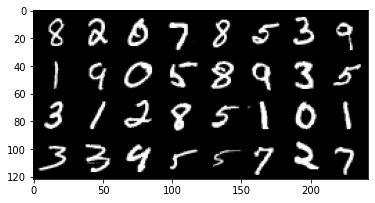

In [ ]:
logical_batch_size = 512
max_physical_batch_size = 128

train_loader = torch.utils.data.DataLoader(downsampled_train_data, logical_batch_size)
test_loader = torch.utils.data.DataLoader(test_data, logical_batch_size)
student_loader = torch.utils.data.DataLoader(student_subset, logical_batch_size)

imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs[:32])
plt.figure()
show(grid)

## Training

In [ ]:
id = f"MNIST"

### Helpers

In [ ]:
class NonUniformPoissonSampler(Sampler[List[int]]):
    def __init__(self, weights: Sequence[float], num_samples: int, sample_rate: float):
        assert num_samples > 0
        assert len(weights) == num_samples

        self.num_samples = num_samples
        self.sample_rate = sample_rate
        self.weighted_sample_rates = torch.as_tensor(sample_rate * weights * num_samples, dtype=torch.double)

    def __len__(self):
        return int(1 / self.sample_rate)

    def __iter__(self):
        num_batches = int(1 / self.sample_rate)
        while num_batches > 0:
            mask = torch.rand(self.num_samples) < self.weighted_sample_rates
            indices = mask.nonzero(as_tuple=False).reshape(-1).tolist()
            yield indices

            num_batches -=1

def reweigh(dataset, labels):
    num_samples = len(dataset)
    m_mask = labels == 1
    f_mask = labels == 0

    males = np.count_nonzero(m_mask)
    females = num_samples - males

    weights = np.zeros(num_samples)
    weights[m_mask] = 0.5 / males
    weights[f_mask] = 0.5 / females

    return torch.as_tensor(weights, dtype=torch.double)

def latent_reweigh(dataset, vae, alpha=0.01, k=16):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=logical_batch_size)

    mus = []
    for imgs, _ in dataloader:
        mu, logvar = vae.encode(imgs.to(device))
        mus.append(mu.cpu().detach().numpy())
        
    mu = np.concatenate(mus)

    bin_edges = np.histogram_bin_edges(mu.reshape(-1), bins=k)
    bin_edges[0] = float("-inf")
    bin_edges[-1] = float("inf")

    weights = np.zeros(len(dataset))
    latent_dim = mu.shape[1]
    for i in range(latent_dim):
        hist = np.histogram(mu[:, i], density=True, bins=bin_edges)[0]
        bin_idxs = np.digitize(mu[:, i], bin_edges)

        hist += alpha
        hist = hist / np.sum(hist)

        p = 1.0 / (hist[bin_idxs - 1])
        p /= p.sum()
        
        weights = np.maximum(weights, p)

    weights /= weights.sum()

    return weights

def remove_hooks(model):
    model._backward_hooks = OrderedDict()
    model._forward_hooks = OrderedDict()
    model._forward_pre_hooks = OrderedDict()
    for child in model.children():
        remove_hooks(child)

def save_model(model, name, jit=True):
    path = "/content/gdrive/MyDrive/Thesis/Models/"
    remove_hooks(model)

    if jit:
        data = next(iter(train_loader))[0]
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model.cpu(), (data), check_trace=False), path + f"{name}.pth")
    else:
        torch.save(model, path + f"{name}.pth")

def save_metrics(metrics, name):
    path = "/content/gdrive/MyDrive/Thesis/Metrics/"

    with open(path + f"{name}.json", 'w') as f:
        json.dump(metrics, f)
        f.close()

def load_model(name, jit=True):
    path = "/content/gdrive/MyDrive/Thesis/Models/"

    if jit:
        return torch.jit.load(path + f"{name}.pth")
    
    return torch.load(path + f"{name}.pth")

def load_metrics(name):
    path = "/content/gdrive/MyDrive/Thesis/Metrics/"

    with open(path + f"{name}.json", 'r') as f:
        metrics = json.load(f)
        f.close()

    return metrics

def evaluate(model, test_loader, verbose=True, return_outputs=False):
    model.eval()

    correct = 0
    total = 0
    pred_list = []
    raw_outputs = []
    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)
            raw_outputs.append(output)

    acc = correct / len(test_loader.dataset)

    if verbose:
        print(f"Test Accuracy: {acc * 100:.6f}")

    if return_outputs:
        return np.concatenate(pred_list), np.concatenate(raw_outputs)

    return np.concatenate(pred_list)

def shape_safe(x):
    return x.shape if hasattr(x, "shape") else ()

def wrap_collate_with_empty(data_loader):
    sample_empty_shapes = [[0, *shape_safe(x)] for x in data_loader.dataset[0]]
    def collate(batch):
        if len(batch) > 0:
            return torch.utils.data._utils.collate.default_collate(batch)
        else:
            return [torch.zeros(x) for x in sample_empty_shapes]

    return collate

def data_loader_with_sampler(data_loader, batch_sampler):
    return torch.utils.data.DataLoader(
        dataset=data_loader.dataset,
        batch_sampler=batch_sampler,
        num_workers=data_loader.num_workers,
        collate_fn=wrap_collate_with_empty(data_loader),
        pin_memory=data_loader.pin_memory,
        timeout=data_loader.timeout,
        worker_init_fn=data_loader.worker_init_fn,
        multiprocessing_context=data_loader.multiprocessing_context,
        generator=data_loader.generator,
        prefetch_factor=data_loader.prefetch_factor,
        persistent_workers=data_loader.persistent_workers,
    )

### Models

In [ ]:
class VanillaCNN(nn.Module):
    def __init__(self):
        super(VanillaCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=(32 * 7 * 7), out_features=100),
            nn.Linear(in_features=100, out_features=10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.cnn(x)


class VanillaVAE(nn.Module):
    def __init__(self, latent_dim):
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
        )

        self.mu_layer = nn.Linear(in_features=(32 * 7 * 7), out_features=latent_dim)
        self.logvar_layer = nn.Linear(in_features=(32 * 7 * 7), out_features=latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=(32 * 7 * 7)),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        out = self.encoder(x)
        mu = self.mu_layer(out)
        logvar = self.logvar_layer(out)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(logvar * 0.5)

    def decode(self, z):
        return self.decoder(z)

    def loss_function(self, recon_x, x, mu, logvar, beta):
        recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum")
        kl_div = 0.5 * torch.sum(torch.exp(logvar) + mu.pow(2) - 1 - logvar)
        return recon_loss + beta * kl_div
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

### Latent Space Analysis

#### Train VAE

Total number of parameters is: 93953


100%|██████████| 107/107 [00:04<00:00, 21.60it/s]


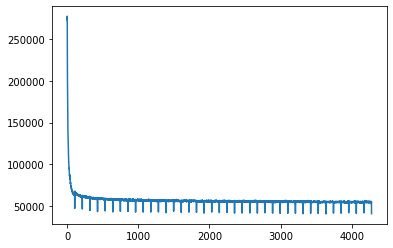

In [ ]:
N = len(train_loader.dataset)
weighted_sampler = torch.utils.data.WeightedRandomSampler(np.ones(N) / N, N)
vae_train_loader = torch.utils.data.DataLoader(downsampled_train_data,
                                               batch_size=train_loader.batch_size,
                                               sampler=weighted_sampler)

num_epochs = 40
learning_rate = 5e-3
latent_dim = 16
beta = 1

vae = VanillaVAE(latent_dim).to(device)
params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

vae.train()
losses = []

for epoch in range(num_epochs):
    for img, _ in tqdm(vae_train_loader):
        optimizer.zero_grad()
        
        x = img.to(device)
        recon_x, mu, logvar = vae(x)

        loss = vae.loss_function(recon_x, x, mu, logvar, beta)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    weights = latent_reweigh(vae_train_loader.dataset, vae)
    vae_train_loader.sampler.weights = torch.as_tensor(weights, dtype=torch.double)


# save_model(vae, f"VAE({id})", jit=False)
plt.plot(losses)
plt.show()

#### Analysis

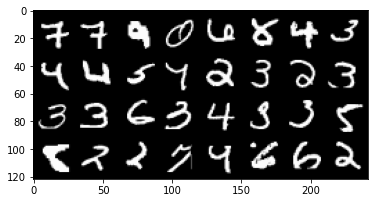

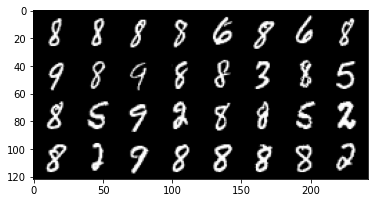

In [ ]:
# vae = load_model(f"VAE({id})", jit=False)

vae.eval()
vae.to(device)

# weights = latent_reweigh(train_loader.dataset, vae, alpha=0.01, k=16)

argsort = weights.argsort()
top = argsort[-32:]
bottom = argsort[:32]

input = torch.stack(tuple(zip(*train_loader.dataset))[0])[top]
img = torchvision.utils.make_grid(input)
plt.figure()
show(img)

input = torch.stack(tuple(zip(*train_loader.dataset))[0])[bottom]
img = torchvision.utils.make_grid(input)
plt.figure()
show(img)

In [ ]:
# dataloader = torch.utils.data.DataLoader(train_loader.dataset, batch_size=logical_batch_size)
# alpha = 0.01
# k = 16

# mus = []
# for imgs, _ in dataloader:
#     mu, logvar = vae.encode(imgs.to(device))
#     mus.append(mu.cpu().detach().numpy())
    
# mu = np.concatenate(mus)

# bin_edges = np.histogram_bin_edges(mu.reshape(-1), bins=k)
# bin_edges[0] = float("-inf")
# bin_edges[-1] = float("inf")

# weights = np.zeros(len(train_loader.dataset))
# latent_dim = mu.shape[1]
# for i in range(latent_dim):
#     hist = np.histogram(mu[:, i], density=True, bins=bin_edges)[0]
#     bin_idxs = np.digitize(mu[:, i], bin_edges)

#     hist += alpha
#     hist = hist / np.sum(hist)

#     p = 1.0 / (hist[bin_idxs - 1])
#     p /= p.sum()
    
#     weights += np.log(p + 1)

# weights /= weights.sum()

In [ ]:
labels = np.array(tuple(zip(*train_loader.dataset))[1])
for i in range(10):
    print(i, weights[labels == i].mean())

0 1.7775885600968645e-05
1 1.1090024568896868e-05
2 2.4135034464980527e-05
3 2.099147143274656e-05
4 3.513856589276445e-05
5 2.3089663425445282e-05
6 1.824207653523578e-05
7 1.7741791108500474e-05
8 1.630677606486537e-05
9 1.516070127482057e-05


100%|██████████| 107/107 [00:04<00:00, 25.78it/s]


(array([5923., 6742., 5958., 6131.,  500., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

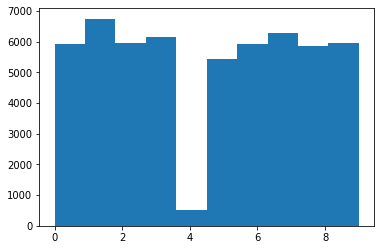

In [ ]:
seen_labels = []
for imgs, labels in tqdm(train_loader):
    seen_labels.append(labels)

plt.hist(np.concatenate(seen_labels))

100%|██████████| 107/107 [00:04<00:00, 25.79it/s]


(array([5679., 4099., 7963., 6974.,  921., 6982., 5956., 6071., 5114.,
        4899.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

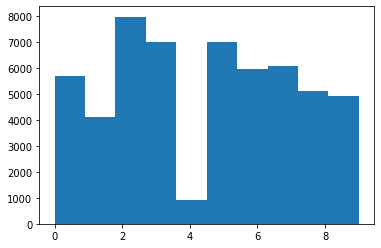

In [ ]:
seen_labels = []
for imgs, labels in tqdm(vae_train_loader):
    seen_labels.append(labels)

plt.hist(np.concatenate(seen_labels))

100%|██████████| 107/107 [00:04<00:00, 25.17it/s]


(array([5667., 4095., 8077., 6931.,  966., 6782., 5885., 6161., 5203.,
        4892.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

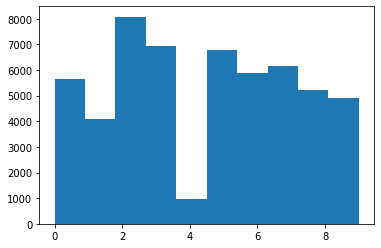

In [ ]:
batch_sampler = NonUniformPoissonSampler(
    weights=weights,
    num_samples=len(train_loader.dataset),
    sample_rate=(1 / len(train_loader))
)

fair_loader = data_loader_with_sampler(train_loader, batch_sampler)

seen_labels = []
for imgs, labels in tqdm(fair_loader):
    seen_labels.append(labels)

plt.hist(np.concatenate(seen_labels))

### Training Code

#### Vanilla Model

In [156]:
def train_vanilla(train_loader, model_class, optim_class, loss_fn, epochs, **kwargs):
    model = model_class()
    model.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_loader.dataset,
        batch_size=train_loader.batch_size, 
        shuffle=True
    )

    criterion = loss_fn
    optimizer = optim_class(model.parameters(), **kwargs)

    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accuracies = []

        for i, (images, target) in enumerate(tqdm(train_loader)):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            acc = (preds == labels).mean()

            epoch_losses.append(loss.item())
            epoch_accuracies.append(acc)

            loss.backward()
            optimizer.step()

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc@1: {np.mean(epoch_accuracies) * 100:.6f} "
        )

        losses.extend(epoch_losses)
        accuracies.extend(epoch_accuracies)

    metrics = { "loss": losses, "accuracy": accuracies }
    return model, metrics

#### DPSGD Model

In [157]:
def train_dpsgd(train_loader, model_class, optim_class, loss_fn, epsilon, delta, max_grad_norm, epochs, **kwargs):
    model = model_class()
    model = ModuleValidator.fix(model)
    assert ModuleValidator.validate(model, strict=False) == []

    model = model.to(device)

    criterion = loss_fn
    optimizer = optim_class(model.parameters(), **kwargs)
    privacy_engine = PrivacyEngine()

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=epochs,
        target_epsilon=epsilon,
        target_delta=delta,
        max_grad_norm=max_grad_norm,
    )
    
    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accuracies = []
        
        with BatchMemoryManager(
            data_loader=train_loader, 
            max_physical_batch_size=max_physical_batch_size, 
            optimizer=optimizer
        ) as memory_safe_data_loader:

            for i, (images, target) in enumerate(tqdm(memory_safe_data_loader)):   
                optimizer.zero_grad()
                model.zero_grad()
                
                images = images.to(device)
                target = target.to(device)

                output = model(images)
                loss = criterion(output, target)

                preds = np.argmax(output.detach().cpu().numpy(), axis=1)
                labels = target.detach().cpu().numpy()

                acc = (preds == labels).mean()

                epoch_losses.append(loss.item())
                epoch_accuracies.append(acc)

                loss.backward()
                optimizer.step()

            epsilon = privacy_engine.get_epsilon(delta)

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc@1: {np.mean(epoch_accuracies) * 100:.6f} "
            f"(ε = {epsilon:.2f}, δ = {delta})"
        )

        losses.extend(epoch_losses)
        accuracies.extend(epoch_accuracies)

    metrics = { "loss": losses, "accuracy": accuracies }
    return model, metrics

#### Weighted DPSGD Model

In [158]:
def train_dpsgd_weighted(train_loader, model_class, optim_class, loss_fn, epsilon, delta,
                         max_grad_norm, epochs, weighting, **kwargs):

    print("Reweighing...")
    
    if weighting == "latent":
        kws = {}
        for key in ["alpha", "k"]:
            if key in kwargs:
                kws[key] = kwargs.pop(key)

        weights = latent_reweigh(train_loader.dataset, vae, **kws)
    elif weighting == "sensitive_attr":
        labels = kwargs.pop("labels")
        weights = reweigh(train_loader.dataset, labels)
    elif weighting == "custom":
        weights = kwargs.pop("weights")
    else:
        raise ValueError("weighting must be one of ['latent', 'sensitive_attr', 'custom']")

    model = model_class()
    model = ModuleValidator.fix(model)
    assert ModuleValidator.validate(model, strict=False) == []

    model.to(device)

    criterion = loss_fn
    optimizer = optim_class(model.parameters(), **kwargs)

    model = GradSampleModule(model)
    model.register_forward_pre_hook(forbid_accumulation_hook)

    sample_rate = 1 / len(train_loader)
    expected_batch_size = int(len(train_loader.dataset) * sample_rate)

    batch_sampler = NonUniformPoissonSampler(
        weights=weights,
        num_samples=len(train_loader.dataset),
        sample_rate=sample_rate
    )

    train_loader = data_loader_with_sampler(train_loader, batch_sampler)

    accountant = RDPAccountant()
    optimizer = DPOptimizer(
        optimizer=optimizer,
        noise_multiplier=get_noise_multiplier(
            target_epsilon=epsilon,
            target_delta=delta,
            sample_rate=sample_rate,
            epochs=epochs,
            accountant=accountant.mechanism()
        ),
        max_grad_norm=max_grad_norm,
        expected_batch_size=expected_batch_size,
    )

    optimizer.attach_step_hook(accountant.get_optimizer_hook_fn(sample_rate=sample_rate))

    model.train()
    losses = []
    accuracies = []

    print("Training Model...")

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accuracies = []
        
        with BatchMemoryManager(
            data_loader=train_loader, 
            max_physical_batch_size=max_physical_batch_size, 
            optimizer=optimizer
        ) as memory_safe_data_loader:

            for i, (images, target) in enumerate(tqdm(memory_safe_data_loader)):   
                optimizer.zero_grad()
                images = images.to(device)
                target = target.to(device)

                output = model(images)
                loss = criterion(output, target)

                preds = np.argmax(output.detach().cpu().numpy(), axis=1)
                labels = target.detach().cpu().numpy()

                acc = (preds == labels).mean()

                epoch_losses.append(loss.item())
                epoch_accuracies.append(acc)

                loss.backward()
                optimizer.step()

            epsilon = accountant.get_epsilon(delta)

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc@1: {np.mean(epoch_accuracies) * 100:.6f} "
            f"(ε = {epsilon:.2f}, δ = {delta})"
        )

        losses.extend(epoch_losses)
        accuracies.extend(epoch_accuracies)

    metrics = { "loss": losses, "accuracy": accuracies }
    return model, metrics

#### Train PATE

In [159]:
def train_pate(train_loader, student_loader, model_class, optim_class, loss_fn, n_teachers,
               epsilon, delta, epochs, **kwargs):
    
    teacher_loaders = []
    n_train = len(train_loader.dataset)
    data_size = n_train // n_teachers
    for i in range(n_teachers):
        idxs = list(range(i * data_size, max((i + 1) * data_size, n_train)))
        subset_data = torch.utils.data.Subset(train_loader.dataset, idxs)
        loader = torch.utils.data.DataLoader(
            subset_data,
            batch_size=train_loader.batch_size,
            shuffle=True
        )
        teacher_loaders.append(loader)

    criterion = loss_fn
    teachers = []

    print(f"Training {n_teachers} Teacher Models...")

    for i in range(n_teachers):
        model = model_class()
        model.to(device)
        optimizer = optim_class(model.parameters(), **kwargs)

        model.train()

        for epoch in tqdm(range(epochs)):
            epoch_losses = []
            epoch_accuracies = []

            for images, target in teacher_loaders[i]:   
                optimizer.zero_grad()
                images = images.to(device)
                target = target.to(device)

                output = model(images)
                loss = criterion(output, target)

                preds = np.argmax(output.detach().cpu().numpy(), axis=1)
                labels = target.detach().cpu().numpy()

                acc = (preds == labels).mean()

                epoch_losses.append(loss.item())
                epoch_accuracies.append(acc)

                loss.backward()
                optimizer.step()
        
        teachers.append(model.cpu())

        print(
            f"Teacher Model: {i + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc@1: {np.mean(epoch_accuracies) * 100:.6f} "
        )
    
    print("Aggregating Teachers...")

    n_train_student = len(student_loader.dataset)
    preds = torch.zeros((n_teachers, n_train_student), dtype=torch.long)
    for i, model in enumerate(tqdm(teachers)):
        outputs = torch.zeros(0, dtype=torch.long)

        model.eval()
        for images, target in student_loader:
            output = model(images)
            ps = torch.argmax(output, dim=1)
            outputs = torch.cat((outputs, ps))

        preds[i] = outputs

    bins = preds.max() + 1
    label_counts = torch.zeros((n_train_student, bins), dtype=torch.long)
    for col in preds:
        label_counts[np.arange(n_train_student), col] += 1

    beta = 1 / epsilon
    label_counts += np.random.laplace(0, beta, 1)
    labels = label_counts.argmax(dim=1)

    def gen_student_loader(student_loader, labels):
        for i, (imgs, _) in enumerate(iter(student_loader)):
            yield imgs, labels[i * len(imgs): (i + 1) * len(imgs)]

    student_model = model_class()
    student_model.to(device)

    optimizer = optim_class(student_model.parameters(), **kwargs)

    student_model.train()
    losses = []
    accuracies = []

    print("Training Student Model...")

    for epoch in range(epochs):
        epoch_losses = []
        epoch_accuracies = []

        generator = gen_student_loader(student_loader, labels)
        for i, (images, target) in enumerate(tqdm(generator, total=len(student_loader))):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            output = student_model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            lbls = target.detach().cpu().numpy()

            acc = (preds == lbls).mean()

            epoch_losses.append(loss.item())
            epoch_accuracies.append(acc)

            loss.backward()
            optimizer.step()

        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(epoch_losses):.6f} "
            f"Acc@1: {np.mean(epoch_accuracies) * 100:.6f} "
        )

        losses.extend(epoch_losses)
        accuracies.extend(epoch_accuracies)

    metrics = { "student_loss": losses, "student_accuracy": accuracies }
    return student_model, metrics

### Training Vanilla

In [160]:
model_vanilla, metrics_vanilla = train_vanilla(
    train_loader=train_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    epochs=4
)

100%|██████████| 107/107 [00:04<00:00, 21.55it/s]


Train Epoch: 1 Loss: 0.274651 Acc@1: 91.781866 


100%|██████████| 107/107 [00:05<00:00, 21.00it/s]


Train Epoch: 2 Loss: 0.066069 Acc@1: 98.073139 


100%|██████████| 107/107 [00:04<00:00, 21.51it/s]


Train Epoch: 3 Loss: 0.046178 Acc@1: 98.579953 


100%|██████████| 107/107 [00:04<00:00, 21.69it/s]

Train Epoch: 4 Loss: 0.033771 Acc@1: 98.993040 


In [161]:
evaluate(model_vanilla, test_loader);

Test Accuracy: 98.220000


### Train DPSGD

In [155]:
model_dpsgd, metrics_dpsgd = train_dpsgd(
    train_loader=train_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    epsilon=1,
    delta=1e-5,
    max_grad_norm=1.2,
    epochs=4
)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:115: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."
  0%|          | 0/427 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing so

Train Epoch: 1 Loss: 0.637484 Acc@1: 82.422995 (ε = 0.75, δ = 1e-05)


482it [00:09, 51.57it/s]


Train Epoch: 2 Loss: 0.294956 Acc@1: 92.066899 (ε = 0.84, δ = 1e-05)


482it [00:09, 51.19it/s]


Train Epoch: 3 Loss: 0.234033 Acc@1: 94.080745 (ε = 0.93, δ = 1e-05)


474it [00:09, 51.11it/s]

Train Epoch: 4 Loss: 0.204576 Acc@1: 94.929403 (ε = 1.00, δ = 1e-05)


In [162]:
evaluate(model_dpsgd, test_loader);

Test Accuracy: 92.990000


### Training DPSGD Weighted

In [150]:
model_dpsgdw, metrics_dpsgdw = train_dpsgd_weighted(
    train_loader=train_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    epsilon=1,
    delta=1e-5,
    max_grad_norm=1.2,
    epochs=4,
    weighting="custom",
    weights=weights
)

Reweighing...


/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


Training Model...


  0%|          | 0/107 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
476it [00:08, 54.83it/s]


Train Epoch: 1 Loss: 0.747652 Acc@1: 78.111627 (ε = 0.75, δ = 1e-05)


474it [00:08, 56.81it/s]


Train Epoch: 2 Loss: 0.368342 Acc@1: 90.103446 (ε = 0.84, δ = 1e-05)


481it [00:08, 56.12it/s]


Train Epoch: 3 Loss: 0.283080 Acc@1: 92.748319 (ε = 0.93, δ = 1e-05)


474it [00:08, 54.04it/s]

Train Epoch: 4 Loss: 0.245207 Acc@1: 94.000374 (ε = 1.00, δ = 1e-05)


In [163]:
evaluate(model_dpsgdw, test_loader);

Test Accuracy: 94.140000


### Training PATE


In [164]:
model_pate, metrics_pate = train_pate(
    train_loader=train_loader,
    student_loader=student_loader,
    model_class=VanillaCNN,
    optim_class=optim.NAdam,
    loss_fn=nn.NLLLoss(),
    n_teachers=4,
    epsilon=1,
    delta=1e-5,
    epochs=4,
)

Training 4 Teacher Models...


100%|██████████| 4/4 [00:19<00:00,  4.85s/it]


Teacher Model: 1 Loss: 0.031554 Acc@1: 99.015616 


100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


Teacher Model: 2 Loss: 0.040648 Acc@1: 98.830536 


100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Teacher Model: 3 Loss: 0.050211 Acc@1: 98.518377 


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Teacher Model: 4 Loss: 0.069519 Acc@1: 98.084474 
Aggregating Teachers...


100%|██████████| 4/4 [00:18<00:00,  4.66s/it]


Training Student Model...


100%|██████████| 98/98 [00:04<00:00, 22.28it/s]


Train Epoch: 1 Loss: 0.761337 Acc@1: 74.776786 


100%|██████████| 98/98 [00:04<00:00, 22.11it/s]


Train Epoch: 2 Loss: 0.515276 Acc@1: 83.127392 


100%|██████████| 98/98 [00:04<00:00, 22.58it/s]


Train Epoch: 3 Loss: 0.452353 Acc@1: 85.097504 


100%|██████████| 98/98 [00:04<00:00, 22.56it/s]

Train Epoch: 4 Loss: 0.424628 Acc@1: 86.256378 


In [165]:
evaluate(model_pate, test_loader);

Test Accuracy: 87.930000


## Fairness Analysis

In [166]:
id = f"MNIST"

# model_vanilla = load_model(f"Vanilla({id})")
# metrics_vanilla = load_metrics(f"Vanilla({id})")

# model_dpsgd = load_model(f"DPSGD({id})")
# metrics_dpsgd = load_metrics(f"DPSGD({id})")

# model_dpsgdw = load_model(f"DPSGD_W({id})")
# metrics_dpsgdw = load_metrics(f"DPSGD_W({id})")

# model_pate = load_model(f"PATE({id})")
# metrics_pate = load_metrics(f"PATE({id})")

In [167]:
preds_vanilla, outs_vanilla = evaluate(model_vanilla.to(device), test_loader, return_outputs=True)
preds_dpsgd, outs_dpsgd = evaluate(model_dpsgd.to(device), test_loader, return_outputs=True)
preds_dpsgdw, outs_dpsgdw = evaluate(model_dpsgdw.to(device), test_loader, return_outputs=True)
preds_pate, outs_pate = evaluate(model_pate.to(device), test_loader, return_outputs=True)

Test Accuracy: 98.220000
Test Accuracy: 92.990000
Test Accuracy: 94.140000
Test Accuracy: 87.930000


In [168]:
df_test = pd.DataFrame()
df_test.loc[:, "label"] = np.array(tuple(zip(*test_data))[1])
df_test.loc[:, "preds_vanilla"] = preds_vanilla.astype(float)
df_test.loc[:, "preds_dpsgd"] = preds_dpsgd.astype(float)
df_test.loc[:, "preds_dpsgdw"] = preds_dpsgdw.astype(float)
df_test.loc[:, "preds_pate"] = preds_pate.astype(float)
df_test.head()

,label,preds_vanilla,preds_dpsgd,preds_dpsgdw,preds_pate
0,7,7.0,7.0,7.0,7.0
1,2,2.0,2.0,2.0,2.0
2,1,1.0,1.0,1.0,1.0
3,0,0.0,0.0,0.0,0.0
4,4,4.0,4.0,4.0,4.0


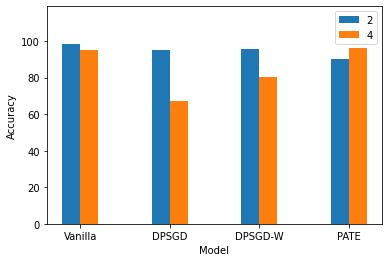

In [169]:
model_names = ["Vanilla", "DPSGD", "DPSGD-W", "PATE"]
nums = [2, downsampled_num]
accuracies = {n: np.zeros(len(model_names)) for n in nums}
for i, model in enumerate(model_names):
    for n in nums:
        df_ = df_test[df_test["label"] == n]
        accuracies[n][i] = np.mean(df_[f"preds_{model.lower().replace('-', '')}"] == df_["label"])

width = 0.2
ind = np.arange(len(model_names))
for i, n in enumerate(nums):
    plt.bar(ind + width * i, accuracies[n] * 100, width, label=str(n))

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(ind + width * (len(nums) - 1) / 2, model_names)
plt.ylim(0, 119)
plt.show()

In [ ]:
accuracies

{2: array([0.99418605, 0.9496124 , 0.96124031, 0.95639535]),
 4: array([0.95519348, 0.47759674, 0.79226069, 0.90631365])}